In [67]:
import os
import re
import sys
import json
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch

import seaborn as sns

import IPython.display

import ipywidgets as widgets

# Contents <a name="contents"></a>

- [General Analysis](#general)
- [Comparison across different number of off-manifold points](#cmpr_num_off_mfld_k2n500)

## General Analysis <a name="general"></a> [\[top\]](#contents)

In [2]:
def disp_query_plot(query, response_df, style):
    if query["task"] == "clf":
        if style == "sct_plot":
            fig = plt.figure()
            plt.title("sct plot not available for stdclf")
            plt.show()
            
        elif style == "adv_pct_cm" or style == "pct_cm":
            f, axarr = plt.subplots(1, 2)
            f.set_size_inches(10, 4)
            img = pd.read_csv(response_df.pct_cm.tolist()[0], index_col=0)
            sns.heatmap(img, ax=axarr[0], annot=True)
            axarr[0].set_title("normal pct cm")
            img = pd.read_csv(response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(img, ax=axarr[1], annot=True)
            axarr[1].set_title("adv pct cm")
            f.set_tight_layout(True)
            plt.show()

    elif query["task"] == "dist":
        clf_query = copy.deepcopy(query)
        clf_query.pop("thresh")
        clf_query["task"] = "clf"
        clf_response_df = master_df[(master_df[list(clf_query.keys())] == pd.Series(clf_query)).all(1)]
        
        inf_query = copy.deepcopy(query)
        inf_query["thresh"] = np.inf
        inf_response_df = master_df[(master_df[list(inf_query.keys())] == pd.Series(inf_query)).all(1)]
        
        if style == "adv_pct_cm":
            fig = plt.figure(constrained_layout=True)
            fig.set_size_inches(16, 4)
            ax_dict = fig.subplot_mosaic(
                [
                    ["dist_inf_adv_pct_cm", "dist_adv_pct_cm", "clf_adv_pct_cm"],
                ]
            )
            
            dist_adv_pct_cm_inf = pd.read_csv(inf_response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(dist_adv_pct_cm_inf, ax=ax_dict["dist_inf_adv_pct_cm"], annot=True)
            ax_dict["dist_inf_adv_pct_cm"].set_title("distlearn: adv pct cm (th=inf)")
            
            dist_adv_pct_cm = pd.read_csv(response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(dist_adv_pct_cm, ax=ax_dict["dist_adv_pct_cm"], annot=True)
            ax_dict["dist_adv_pct_cm"].set_title("distlearn: adv pct cm")

            clf_adv_pct_cm = pd.read_csv(clf_response_df.adv_pct_cm.tolist()[0], index_col=0)
            sns.heatmap(clf_adv_pct_cm, ax=ax_dict["clf_adv_pct_cm"], annot=True)
            ax_dict["clf_adv_pct_cm"].set_title("stdclf: adv pct cm")

        elif style == "pct_cm":
            fig = plt.figure(constrained_layout=True)
            fig.set_size_inches(10, 4)
            ax_dict = fig.subplot_mosaic(
                [
                    ["dist_pct_cm", "clf_pct_cm"]
                ]
            )

            dist_pct_cm = pd.read_csv(response_df.pct_cm.tolist()[0], index_col=0)
            sns.heatmap(dist_pct_cm, ax=ax_dict["dist_pct_cm"], annot=True)
            ax_dict["dist_pct_cm"].set_title("distlearn: pct cm")

            clf_pct_cm = pd.read_csv(clf_response_df.pct_cm.tolist()[0], index_col=0)
            sns.heatmap(clf_pct_cm, ax=ax_dict["clf_pct_cm"], annot=True)
            ax_dict["clf_pct_cm"].set_title("stdclf: pct cm")
            
        elif style == "sct_plot":
            fig = plt.figure(constrained_layout=True)
            fig.set_size_inches(8, 6)
            ax_dict = fig.subplot_mosaic(
                [
                    ["sct_plot"],

                ]
            )

            img = mpimg.imread(response_df.distance_sct_plt.tolist()[0])
            ax_dict["sct_plot"].imshow(img)
            ax_dict["sct_plot"].set_title("distance sct plt")
        
        plt.show()


In [3]:
def make_interactive_query_system(master_df):
    
    INP_COLS = ["atk_flavor", "atk_routine", "eps", "eps_iter", "norm", "restarts", "verbose", "k", "n", "max_norm", "task", "N", "thresh"]

    input_widgets = list()

    for col in INP_COLS:

        uniq_vals = master_df[col].fillna(value=-1).unique()

        input_widgets.append(widgets.Dropdown(
            options=uniq_vals,
            value=uniq_vals[0],
            description=col,
            disabled=False
        ))
    
    
    output_style = widgets.Dropdown(
            options=["adv_pct_cm", "sct_plot", "pct_cm"],
            value="adv_pct_cm",
            description="display style",
            disabled=False
        )
    
    
    
    button = widgets.Button(
        description='Submit',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Submit',
        icon='check' # (FontAwesome names without the `fa-` prefix)
    )
    
    
    output = widgets.Output()
    input_widgets.append(button)
    display_for_inputs = widgets.GridBox(input_widgets[:-1] + [output_style] + [input_widgets[-1]], layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))
    display(display_for_inputs)
    
    def on_button_clicked(b):
        with output:
            IPython.display.clear_output(wait=True) 
            query = {i.description: i.value for i in input_widgets[:-1]}
            if query["task"] == "clf": query.pop("thresh")

            display_for_inputs = widgets.GridBox(input_widgets[:-1] + [output_style] + [input_widgets[-1]], layout=widgets.Layout(grid_template_columns="repeat(3, 300px)"))
            response_df = master_df[(master_df[list(query.keys())] == pd.Series(query)).all(1)]
            style = output_style.value
            disp_query_plot(query, response_df, style)
        
        display(display_for_inputs)  
        display(output)
        IPython.display.clear_output(wait=True) 
            
    input_widgets[-1].on_click(on_button_clicked)
    IPython.display.clear_output(wait=True)   

In [4]:
DUMP_DIR = "../../dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs_fixed_07022022/"
tag_match = ["moreoffmfld", "clf"]
tag_not_match = ["v2", "v3"]
master_df = None

for file in os.listdir(DUMP_DIR):
    if not file.endswith(".json"):
        print(file)
        continue
    skip = False
    for match in tag_match:
        if match not in file:
            skip=True
        elif match in file:
            skip=False
            break
    for match in tag_not_match:
        if match in file:
            skip=True
    if skip:
        print(file)
        continue
    if master_df is None:
        master_df = pd.read_json(os.path.join(DUMP_DIR, file))
    else:

        tmp = pd.read_json(os.path.join(DUMP_DIR, file))
        master_df = pd.concat([master_df, tmp], ignore_index=True)

columns = master_df.columns.tolist()
drop_dup_by_columns = [i for i in columns if "clf_report" not in i]
master_df.drop_duplicates(drop_dup_by_columns, inplace=True)

rdm_concspheres_k2n500_noninfdist_moreoffmfldv2-regression.json
rdm_concspheres_k2n500_noninfdist_upmn-regression.json
rdm_concspheres_k2n500_noninfdist-regression.json
rdm_concspheres_k50n500_noninfdist-regression.json
rdm_concspheres_k500n500_noninfdist-regression.json
.ipynb_checkpoints


In [5]:
make_interactive_query_system(master_df)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

# Comparing across different number of off-manifold points <a name="cmpr_num_off_mfld_k2n500"></a> [\[top\]](#contents)

- For k = 2, n = 500: load v2 and normal run separately
- For k = 50, n = 500: load v3 and normal run separately

In [6]:
DUMP_DIR = "../../dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs_fixed_07022022/"


k2n500_dl_v1 = os.path.join(DUMP_DIR, "rdm_concspheres_k2n500_noninfdist_moreoffmfld-regression.json")
k2n500_dl_v2 = os.path.join(DUMP_DIR, "rdm_concspheres_k2n500_noninfdist_moreoffmfldv2-regression.json")
k2n500_stdclf = os.path.join(DUMP_DIR, "rdm_concspheres_k2n500_noninfdist-clf.json")




In [7]:
v1_list = [
    k2n500_dl_v1,
    k2n500_stdclf
]
master_df_v1 = None
for file in v1_list:
    if not file.endswith(".json"):
        continue
    if master_df_v1 is None:
        master_df_v1 = pd.read_json(file)
    else:
        tmp = pd.read_json(file)
        master_df_v1 = pd.concat([master_df_v1, tmp], ignore_index=True)

columns_v1 = master_df_v1.columns.tolist()
drop_dup_by_columns_v1 = [i for i in columns_v1 if "clf_report" not in i]
master_df_v1.drop_duplicates(drop_dup_by_columns_v1, inplace=True)


v2_list = [
    k2n500_dl_v2,
    k2n500_stdclf
]
master_df_v2 = None
for file in v2_list:
    if not file.endswith(".json"):
        continue
    if master_df_v2 is None:
        master_df_v2 = pd.read_json(file)
    else:
        tmp = pd.read_json(file)
        master_df_v2 = pd.concat([master_df_v2, tmp], ignore_index=True)

columns_v2 = master_df_v2.columns.tolist()
drop_dup_by_columns_v2 = [i for i in columns_v2 if "clf_report" not in i]
master_df_v2.drop_duplicates(drop_dup_by_columns_v2, inplace=True)


In [8]:
make_interactive_query_system(master_df_v1)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

In [9]:
make_interactive_query_system(master_df_v2)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

# Comparing performance by runs <a name="general"></a> [\[top\]](#contents)

In [10]:
RES_DIR = "/data/dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs/"

all_run_files = [i for i in os.listdir(RES_DIR) if i.endswith(".json")]
checkbox_map = {i: widgets.Checkbox(
        value=False,
        description=i,
        disabled=False,
        indent=False,
        layout=widgets.Layout(width='100%')
    ) for i in all_run_files}

multiselect = widgets.SelectMultiple(
    options=all_run_files,
    description='Runs',
    disabled=False,
    rows=10,
    layout=widgets.Layout(width='100%')
)
# gridbox = widgets.GridBox(, layout=widgets.Layout(grid_template_columns="repeat(1, 800px)"))
display(multiselect)

SelectMultiple(description='Runs', layout=Layout(width='100%'), options=('rdm_concspheres_k2n500_noninfdist_mo…

In [11]:
multiselect.value

('rdm_concspheres_k50n500_noninfdist_moreoffmfld_lrsweeps-regression.json',
 'rdm_concspheres_k50n500_noninfdist_moreoffmfldv2-regression.json',
 'rdm_concspheres_k2n500_noninfdist_upmn-clf.json',
 'rdm_concspheres_k2n500_noninfdist_moreoffmfldv2-regression-Copy1.json')

In [12]:
master_df = None
for f in multiselect.value:
    res_file = os.path.join(RES_DIR, f)
    if master_df is None:
        master_df = pd.read_json(res_file)
    else:
        tmp = pd.read_json(res_file)
        master_df = pd.concat([master_df, tmp], ignore_index=True)
columns = master_df.columns.tolist()
drop_dup_by_columns = [i for i in columns if "clf_report" not in i]
master_df.drop_duplicates(drop_dup_by_columns, inplace=True)

In [13]:
make_interactive_query_system(master_df)

GridBox(children=(Dropdown(description='atk_flavor', options=('std_pgd',), value='std_pgd'), Dropdown(descript…

# Effect of `eps_iter`

for given runs, show how variation of eps_iter affects the performance across epsilons. (1 line for each `eps_iter`)

In [14]:
RES_DIR = "/data/dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs/"

all_run_files = [i for i in os.listdir(RES_DIR) if i.endswith(".json")]

select = widgets.Select(
    options=all_run_files,
    description='Runs',
    disabled=False,
    rows=10,
    layout=widgets.Layout(width='100%')
)
# gridbox = widgets.GridBox(, layout=widgets.Layout(grid_template_columns="repeat(1, 800px)"))
display(select)

Select(description='Runs', layout=Layout(width='100%'), options=('rdm_concspheres_k2n500_noninfdist_moreoffmfl…

In [36]:
####### specify threshold for this plot ########

# can be any number between 0.1 t0 0.15 (both inclusive with 0.01 increments) or np.inf
thresh = 0.14

In [33]:
####### Other useful parameters #######
also_show_clf = True
if "clf" in select.value: also_show_clf = False
if also_show_clf:
    all_run_clf_files = [i for i in all_run_files if "clf" in i and i != select.value]
    select_clf = widgets.Select(
        options=all_run_clf_files,
        description='Runs',
        disabled=False,
        rows=10,
        layout=widgets.Layout(width='100%')
    )
    # gridbox = widgets.GridBox(, layout=widgets.Layout(grid_template_columns="repeat(1, 800px)"))
    display(select_clf)

Select(description='Runs', layout=Layout(width='100%'), options=('rdm_concspheres_k2n500_noninfdist_upmn-clf.j…

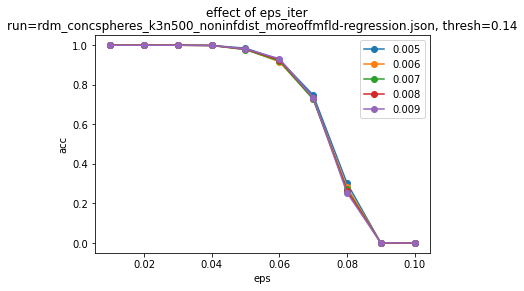

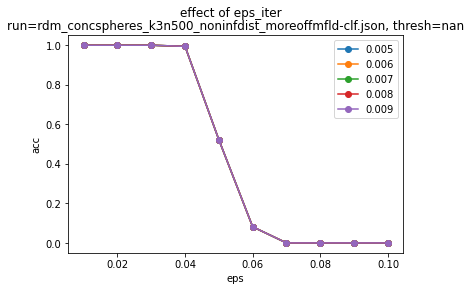

In [37]:
files = [select.value]
if also_show_clf: files.append(select_clf.value)
for f in files:
    df = pd.read_json(os.path.join(RES_DIR, f))
    task = df.task.unique()[0]
    eps_arr = df.eps.unique()
    eps_iter_arr = df.eps_iter.unique()
    plt.figure()
    for eps_iter in eps_iter_arr:
        perf_for_eps_iter = list()
        for eps in eps_arr:
            if task == "clf":
                acc = np.trace(pd.read_csv(df[(df.eps == eps) & (df.eps_iter == eps_iter)].adv_pct_cm.tolist()[0], index_col=0).to_numpy())
            else:
                acc = np.trace(pd.read_csv(df[(np.round(df.thresh, 2) == thresh) & (df.eps == eps) & (df.eps_iter == eps_iter)].adv_pct_cm.tolist()[0], index_col=0).to_numpy())
            perf_for_eps_iter.append(acc)

        plt.plot(eps_arr, perf_for_eps_iter, label=np.round(eps_iter, 3), marker="o")

    plt.legend()
    plt.xlabel("eps")
    plt.ylabel("acc")
    plt.title("run={}, thresh={}".format(f, thresh if task != "clf" else np.nan))
    plt.suptitle("effect of eps_iter")
    plt.show()




# Effect of `k`

In [118]:
RES_DIR = "/data/dumps/expC_dist_learner_for_adv_ex/rdm_concspheres_test/attack_perfs_on_runs/all_attack_perfs/"

all_run_files = [i for i in os.listdir(RES_DIR) if i.endswith("1-regression.json")]

multiselect = widgets.SelectMultiple(
    options=all_run_files,
    description='Select',
    value=all_run_files,
    disabled=False,
    rows=10,
    layout=widgets.Layout(width='100%')
)
# gridbox = widgets.GridBox(, layout=widgets.Layout(grid_template_columns="repeat(1, 800px)"))
display(multiselect)

SelectMultiple(description='Select', index=(0, 1, 2), layout=Layout(width='100%'), options=('rdm_concspheres_k…

In [126]:
print("selected files:")
for i in multiselect.value:
    print(i)

selected files:
rdm_concspheres_k500n500_noninfdist_moreoffmfld-1-regression.json
rdm_concspheres_k10n500_noninfdist_moreoffmfld-1-regression.json
rdm_concspheres_k2n500_noninfdist_moreoffmfld-1-regression.json


In [127]:
#### Assuming here that only one clf file will be used corresponding to one distance learner

dl_files = [os.path.join(RES_DIR, i) for i in copy.deepcopy(multiselect.value)]
tmp = [i.replace("1-regression.json", "*-clf.json") for i in multiselect.value]
clf_files = list()
for i in tmp:
    clf_files.extend([os.path.basename(i) for i in glob.glob(os.path.join(RES_DIR, i))])
    
multiselect_clf = widgets.SelectMultiple(
    options=clf_files,
    description='Select',
    value=clf_files,
    disabled=False,
    rows=10,
    layout=widgets.Layout(width='100%')
)
# gridbox = widgets.GridBox(, layout=widgets.Layout(grid_template_columns="repeat(1, 800px)"))
display(multiselect_clf)


SelectMultiple(description='Select', index=(0, 1), layout=Layout(width='100%'), options=('rdm_concspheres_k500…

In [128]:
print("selected files:")
for f in multiselect_clf.value:
    print(f)

clf_files = [os.path.join(RES_DIR, i) for i in multiselect_clf.value]

selected files:
rdm_concspheres_k500n500_noninfdist_moreoffmfld-renamed-2-clf.json
rdm_concspheres_k2n500_noninfdist_moreoffmfld-renamed-2-clf.json


In [129]:
pair_files = list()

for i in range(len(dl_files)):
    matched = False
    for j in range(len(clf_files)):
        file_common_prefix = re.sub(r"\-[0-9\-]*(regression|clf).json", "", dl_files[i])
        match_obj = re.match(file_common_prefix, clf_files[j])
        if match_obj is not None:
            pair_files.append((dl_files[i], match_obj.string))
            matched=True
        
    if not matched:
        pair_files.append((dl_files[i], None))
            
print("paired files:")
for i in pair_files:
    print(os.path.basename(i[0]), "|", os.path.basename(i[1]) if i[1] is not None else i[1])

paired files:
rdm_concspheres_k500n500_noninfdist_moreoffmfld-1-regression.json | rdm_concspheres_k500n500_noninfdist_moreoffmfld-renamed-2-clf.json
rdm_concspheres_k10n500_noninfdist_moreoffmfld-1-regression.json | None
rdm_concspheres_k2n500_noninfdist_moreoffmfld-1-regression.json | rdm_concspheres_k2n500_noninfdist_moreoffmfld-renamed-2-clf.json


In [141]:
#### setting hyperparameters which will be fixed!!!

thresh = 0.14
eps_iter = 5e-03
show_error_w_clf = False

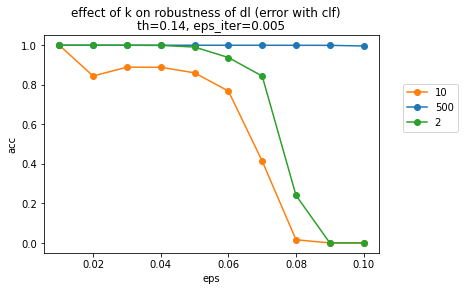

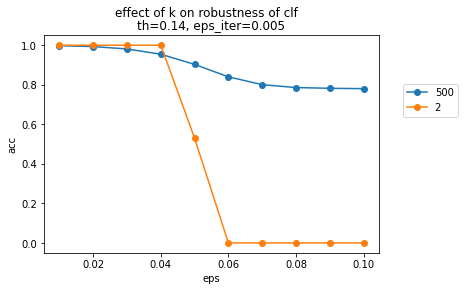

In [142]:
dl_perf_all = list()
clf_perf_all = list()
k_all = list()

plt.figure()
for pair in pair_files:
    dl_df = pd.read_json(pair[0])
    clf_df = pd.read_json(pair[1]) if pair[1] is not None else None
    
    eps_arr = dl_df.eps.unique()
    
    dl_perf = np.zeros(eps_arr.shape)
    clf_perf = np.zeros(eps_arr.shape)
    
    assert dl_df.k.unique().shape[0] == 1
    if clf_df is not None:
        assert clf_df.k.unique().shape[0] == 1
    k = dl_df.k.unique()[0]
    
    for i in range(eps_arr.shape[0]):
        eps = eps_arr[i]
        
        dl_perf[i] = np.trace(pd.read_csv(dl_df[(np.round(dl_df.thresh, 2) == thresh) & \
                                             (dl_df.eps == eps) & \
                                             (np.round(dl_df.eps_iter, 3) == eps_iter)].adv_pct_cm.tolist()[0], index_col=0).to_numpy())
        if clf_df is not None:
            clf_perf[i] = np.trace(pd.read_csv(clf_df[(clf_df.eps == eps) & \
                                             (np.round(clf_df.eps_iter, 3) == eps_iter)].adv_pct_cm.tolist()[0], index_col=0).to_numpy())
    if clf_df is not None:
        diff = dl_perf - clf_perf
        lolim = diff < 0
        uplim = diff >= 0

        if show_error_w_clf:
            plt.errorbar(eps_arr, dl_perf, yerr=diff, uplims=uplim, lolims=lolim, label=k, marker="o", markersize=0.1)
        else:
            plt.errorbar(eps_arr, dl_perf, label=k, marker="o")
    else:
        plt.plot(eps_arr, dl_perf, label=k, marker="o")
        
    dl_perf_all.append(dl_perf)
    clf_perf_all.append(clf_perf if clf_df is not None else None)
    k_all.append(k)

plt.legend(bbox_to_anchor =(1.25, 0.8))
plt.title("th={}, eps_iter={}".format(thresh, eps_iter))
plt.suptitle("effect of k on robustness of dl (error with clf)")
plt.xlabel("eps")
plt.ylabel("acc")
plt.show()



plt.figure()
for i in range(len(clf_perf_all)):
    if clf_perf_all[i] is None:
        continue
    plt.plot(eps_arr, clf_perf_all[i], label=k_all[i], marker="o")

plt.legend(bbox_to_anchor =(1.25, 0.8))
plt.title("th={}, eps_iter={}".format(thresh, eps_iter))
plt.suptitle("effect of k on robustness of clf")
plt.xlabel("eps")
plt.ylabel("acc")
plt.show()


        

6